In [1]:
import glob
import sys
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv 
import pandas as pd
import matplotlib.image as mpimg
import nntools as nt

In [2]:
full_set = glob.glob("/datasets/ee285f-public/PascalVOC2012/JPEGImages/*.jpg")

device='cuda'

In [3]:
training_set = random.sample(full_set, int(0.7*len(full_set)))
val_set = []
for i in range(len(full_set)):
    if full_set[i] not in training_set:
        val_set.append(full_set[i])

In [44]:
im=cv2.imread(training_set[22])

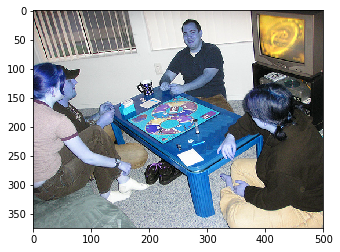

In [47]:
plt.imshow(im)

In [57]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
 

In [58]:
ss.setBaseImage(im)

In [59]:
ss.switchToSelectiveSearchQuality()

In [60]:
rects = ss.process()

In [61]:
print(len(rects))

4285


In [62]:
imOut = im.copy()

In [5]:
for i, rect in enumerate(rects):
            # draw rectangle for region proposal till numShowRects
            if (i < 300):
                x, y, w, h = rect
                bound_box = im[y:y+h, x:x+w]
                new_im = cv2.resize(bound_box, (228, 228))
                #cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

NameError: name 'rects' is not defined

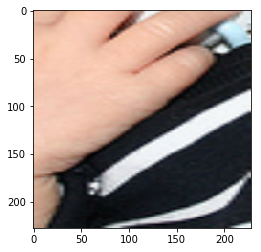

In [64]:
plt.imshow(new_im)

In [6]:
def selective_search(img):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchQuality()
    rects = ss.process()
    np.random.shuffle(rects)
    if len(rects) > 2000:
        bb_list = rects[0:2000]
    else:
        bb_list=rects
    im_bb_list = list()
    for i in range(len(bb_list)):
        x, y, w, h = bb_list[i]
        new_im = cv2.resize(img[y:y+h,x:x+w], (228, 228))
        im_bb_list.append(new_im)
    return im_bb_list



# convert each of this to a tensor for torch support

In [48]:
def toTensor(bb_list):
    list_bb=list()
    for i in range(len(bb_list)):
        transform = tv.transforms.Compose([tv.transforms.ToTensor(),tv.transforms.Normalize([0.5]*3,[0.5]*3)])
        im=transform(bb_list[i])
        list_bb.append(im) 
    return list_bb

In [ ]:
train_set=[]
for i in range(len(training_set)):
    im=cv2.imread(training_set[i])
    l1=selective_search(im)
    l2=toTensor(l1)
    train_set.append(l2)
    print(i," is completed")

0  is completed
1  is completed
2  is completed
3  is completed
4  is completed
5  is completed
6  is completed
7  is completed
8  is completed
9  is completed


In [66]:
class NNClassifier(nt.NeuralNetwork):

    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def criterion(self, y, d):
        return self.cross_entropy(y, d)

In [68]:
class VGG16Transfer(NNClassifier):

    def __init__(self, num_classes, fine_tuning=False):
        super(VGG16Transfer, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        self.features = vgg.features
        self.classifier=vgg.classifier
        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        f=self.features(x)
        f=f.view(f.size(0),-1)
        y = self.classifier(f)
        return y

In [69]:
class ClassificationStatsManager(nt.StatsManager):

    def __init__(self):
        super(ClassificationStatsManager, self).__init__()

    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0

    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        self.running_accuracy += torch.mean((l == d).float())

    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize()
        accuracy = 100*(self.running_accuracy/self.number_update) # COMPLETE
        return {'loss': loss, 'accuracy': accuracy}

In [ ]:
lr = 1e-3
net = VGG16Transfer(num_classes)
net = net.to(device)
print(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="voc1", perform_validation_during_training=True)

In [4]:
len(training_set)

11987